In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['koko-newdata', 'reducing-image-sizes-to-32x32', 'iwildcam-2019-fgvc6', 'densenet']


In [2]:
import os
import json

import numpy as np
import pandas as pd
import keras
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

Using TensorFlow backend.


In [3]:
x_train = np.load('../input/koko-newdata/X_newtrain.npy')
#x_test = np.load('../input/koko-newdata/X_newtest.npy')
x_test = np.load('../input/reducing-image-sizes-to-32x32/X_newtest.npy')
y_train = np.load('../input/koko-newdata/y_newtrain.npy')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (98150, 32, 32, 3)
98150 train samples
9815 test samples


In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

In [5]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=14
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

f1_metrics = Metrics()

In [6]:
densenet = DenseNet121(
    weights='../input/densenet/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(32,32,3)
)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model = Sequential()
model.add(densenet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(14, activation='softmax'))

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1, 1, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                14350     
Total params: 7,051,854
Trainable params: 6,968,206
Non-trainable params: 83,648
_________________________________________________________________


In [10]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=3,
    callbacks=[checkpoint, f1_metrics],
    validation_split=0.05
)

Train on 93242 samples, validate on 4908 samples
Epoch 1/3
93242/93242 [==============================] - 2313s 25ms/step - loss: 0.6166 - acc: 0.8052 - val_loss: 0.5180 - val_acc: 0.8301

Epoch 00001: val_acc improved from -inf to 0.83007, saving model to model.h5


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


val_f1: 0.4900 — val_precision: 0.5334 — val_recall: 0.4756
Epoch 2/3
93242/93242 [==============================] - 2280s 24ms/step - loss: 0.4534 - acc: 0.8535 - val_loss: 0.4130 - val_acc: 0.8608

Epoch 00002: val_acc improved from 0.83007 to 0.86084, saving model to model.h5
val_f1: 0.5775 — val_precision: 0.6449 — val_recall: 0.5528
Epoch 3/3
93242/93242 [==============================] - 2257s 24ms/step - loss: 0.3534 - acc: 0.8837 - val_loss: 0.3949 - val_acc: 0.8674

Epoch 00003: val_acc improved from 0.86084 to 0.86736, saving model to model.h5
val_f1: 0.6065 — val_precision: 0.6577 — val_recall: 0.5874


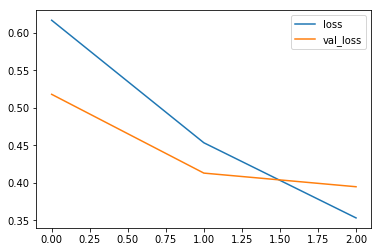

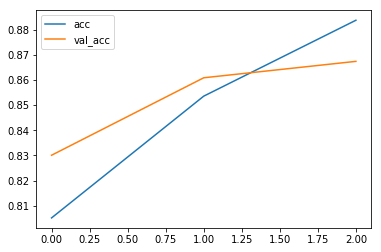

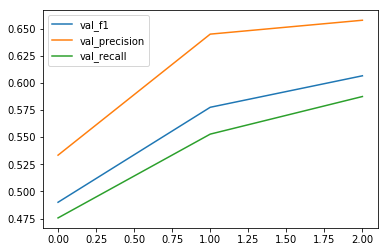

In [11]:
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()
history_df[['val_f1', 'val_precision', 'val_recall']].plot()

In [12]:
model.load_weights('model.h5')
y_train=np.load('../input/koko-newdata/y_coltrain.npy')
y_predict = model.predict(x_train)
y_predict=y_predict.argmax(axis=1)

In [13]:
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score 
from sklearn.metrics import recall_score,precision_score,classification_report 
print('Accuracy:', accuracy_score(y_train, y_predict))
print('F1 score:', f1_score(y_train, y_predict,average='weighted'))
print('Recall:', recall_score(y_train, y_predict,
                              average='weighted'))
print('Precision:', precision_score(y_train, y_predict,
                                    average='weighted'))
print('\n clasification report:\n', classification_report(y_train, y_predict))
print('\n confussion matrix:\n',confusion_matrix(y_train, y_predict))

Accuracy: 0.6838003056546103
F1 score: 0.6832325553012545
Recall: 0.6838003056546103
Precision: 0.683871123261332

 clasification report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     65650
           1       0.92      0.90      0.91      3093
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00      1660
           4       0.01      0.02      0.01      1106
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.03      0.00      0.01      3529
           9       0.00      0.00      0.00         0
          10       0.00      0.01      0.01       529
          11       0.05      0.02      0.03      3577
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00      4286
          14       0.00      0.00      0.00       

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning


 confussion matrix:
 [[64209   115   211   110   172    26   112   109    29    55    27    58
    417     0     0     0     0     0     0     0]
 [  247  2797     0     3     6     3    12     5     4     5     7     2
      2     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [   96     0  1436     0    65     0     4     0     0     3     9    41
      6     0     0     0     0     0     0     0]
 [  117     0     1   873    17     2     1    38     1     3     1     0
     52     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0    

In [14]:
y_test=np.load('../input/koko-newdata/y_coltest.npy')
y_predict_test = model.predict(x_test)
y_predict_test=y_predict_test.argmax(axis=1)

In [15]:
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score 
from sklearn.metrics import recall_score,precision_score,classification_report 
print('Accuracy:', accuracy_score(y_test, y_predict_test))
print('F1 score:', f1_score(y_test, y_predict_test,average='weighted'))
print('Recall:', recall_score(y_test, y_predict_test,
                              average='weighted'))
print('Precision:', precision_score(y_test, y_predict_test,
                                    average='weighted'))
print('\n clasification report:\n', classification_report(y_test, y_predict_test))
print('\n confussion matrix:\n',confusion_matrix(y_test, y_predict_test))

Accuracy: 0.6812022414671421
F1 score: 0.6807824587940099
Recall: 0.6812022414671421
Precision: 0.6829454036877467

 clasification report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      6566
           1       0.88      0.85      0.86       343
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00       185
           4       0.00      0.01      0.00       104
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.09      0.01      0.02       345
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00        58
          11       0.07      0.03      0.04       370
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00       421
          14       0.00      0.00      0.00      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning

In [16]:
def hoeffding_bound(Ein,N,M,confidence):
   delta=1-confidence
   A=np.log(2*M/delta)
   bond=np.sqrt(A/(2*N))
   limit=Ein-bond
   return limit

In [17]:
limit=hoeffding_bound(0.6728471667618514,98150,1,0.95)
print(limit)

0.6685121869234605
